In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from obspy import read
import math

In [2]:
dir_name = 'data/lunar/training'
catalog_name = 'apollo12_catalog_GradeA_final.csv'

In [3]:
# make the plot for a csv file
def make_plot(namelist, arrival_time):
  fig, ax = plt.subplots(5, 1, figsize=(10, 20))
  # go through the catalog
  for i in range(len(namelist.head())):
    # read the csv and put it into a dataframe
    df = pd.read_csv(os.path.join(dir_name + '/data/S12_GradeA', namelist[i] + '.csv'))
    # put both the times and data columns into respective lists
    times = np.array(df['time_rel(sec)'].tolist())
    data = np.array(df['velocity(m/s)'].tolist())
    # make a plot of time vs velocity
    ax[i].plot(times, data)
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Velocity (m/s)')
    # add a red line for the correct arrival time
    ax[i].axvline(x = arrival_time[i], color='red',label='Rel. Arrival')
    arrival_line = ax[i].axvline(x=arrival_time[i], c='red', label='Abs. Arrival')
    ax[i].legend(handles=[arrival_line])

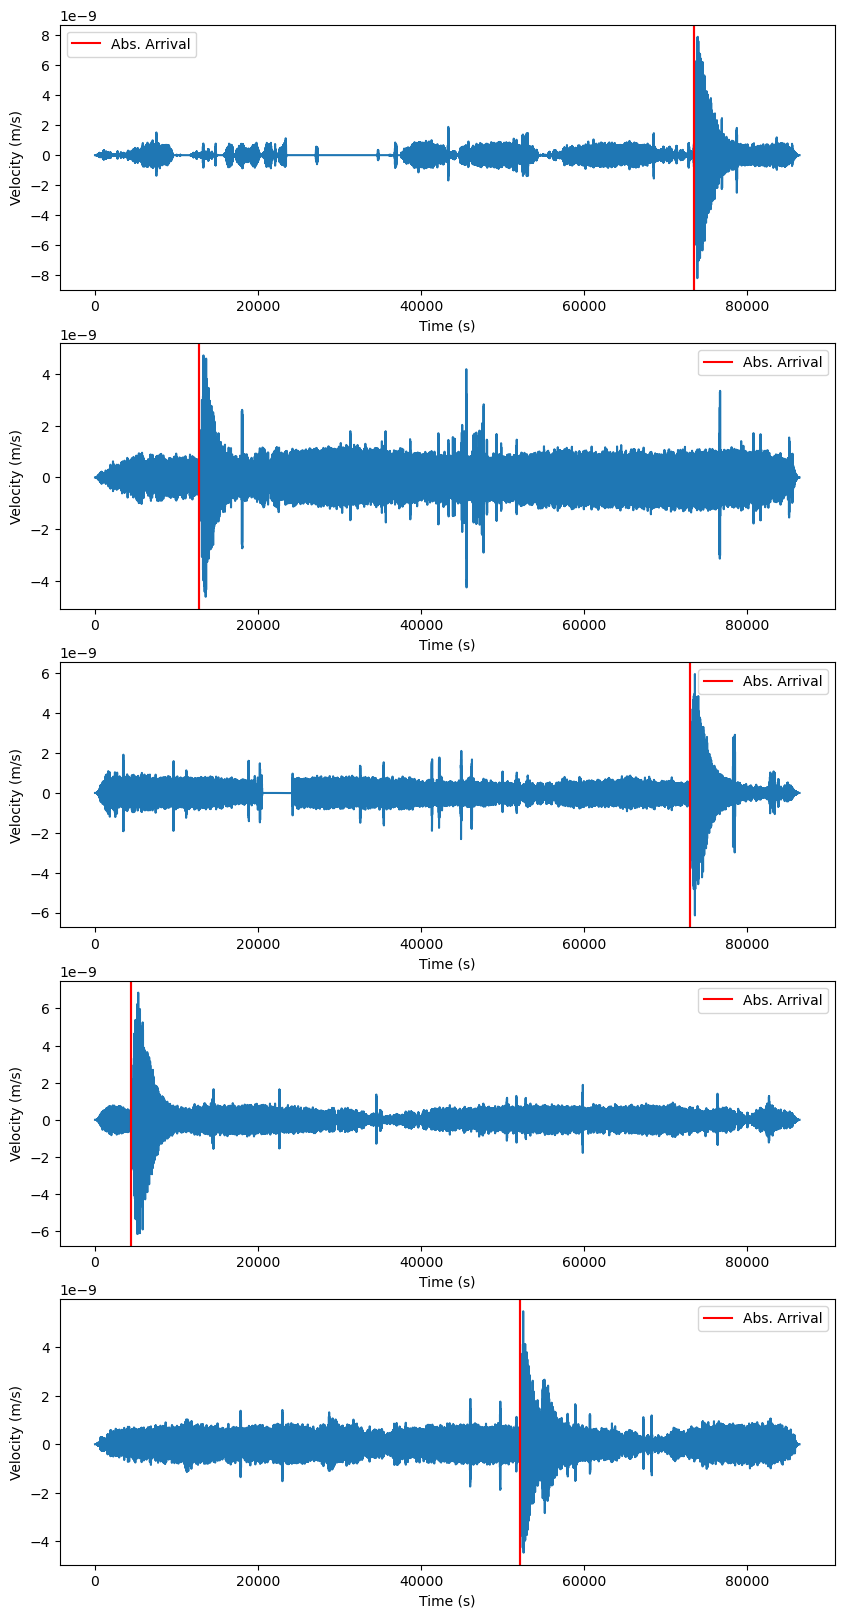

In [4]:
# get catalog dataframe
catalog_df = pd.read_csv(os.path.join(dir_name + '/catalogs/', catalog_name))
catalog_df = catalog_df.drop(catalog_df.index[20]).reset_index(drop=True)
# get list of files
arrival_time_catalog = catalog_df['time_rel(sec)']
filename_catalog = catalog_df['filename']
make_plot(filename_catalog, arrival_time_catalog)

In [5]:
# split a csv into windows
def makeWindows(df, arrival_times, b_bound = 4, f_bound = 8, jump = 50):
  arrival_indices = []
  for arrival_time in arrival_times:
    time_list = df['time_rel(sec)'].tolist()
    for i in range(len(time_list)):
      if math.isclose(time_list[i], arrival_time, abs_tol=0.1):
        arrival_indices += [i]
        break
  velocities = df['velocity(m/s)'].tolist()

  result = []
  for offset in range(0, jump):
    f_pointer = (b_bound + f_bound) * jump + offset
    first_arr = np.array(velocities[0: f_pointer:jump])
    #print(first_arr)
    first_arr = np.array([np.float64(abs(i)) for i in first_arr])
    result = result + [[first_arr, False]]
    f_pointer += jump


    while f_pointer < len(velocities):
      target = f_pointer - (f_bound * jump)
      classification = False
      if target in arrival_indices:
        classification = True
      # print(np.float64(velocities[f_pointer]))
      # print([np.array(result[-1][0][1:]) + np.float64(velocities[f_pointer])])
      result.append([np.concatenate((np.array(result[-1][0][1:]), np.float64(abs(velocities[f_pointer]))), axis=None), classification])
      f_pointer += jump

  return result

In [6]:
# create windows in a big dataframe for any number of csvs
def make_many_windows(count = catalog_df.shape[0], jumps = 50):
  windows_df = pd.DataFrame(columns=['window', 'classification'])
  # keep track of our duplicate csvs (multiple arrival times)
  duplicates = {7:8, 21:22, 35:36, 47:48, 66:67}
  # go through the amount of csv files we want to look at
  for i in range(count):
    if i in duplicates.values():
      continue

    arrival_times = [catalog_df.loc[i, 'time_rel(sec)']]
    if i in duplicates.keys():
      arrival_times.append(catalog_df.loc[duplicates[i], 'time_rel(sec)'])

    filename = catalog_df.loc[i, 'filename']
    csv_df = pd.read_csv(os.path.join(dir_name + '/data/S12_GradeA/', filename + '.csv'))
    new_windows = pd.DataFrame(makeWindows(csv_df, arrival_times, jump = jumps), columns=['window', 'classification'])
    windows_df = pd.concat([windows_df, new_windows])
  return windows_df

In [7]:
windows_df = make_many_windows(20, jumps=200)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [9]:
df = windows_df

In [10]:
test_dir_name = 'data/lunar/test/S12_GradeB/'

In [11]:
# make same type of dataframe for testing data
def make_test_windows(start = 30, count = catalog_df.shape[0], jumps = 50):
  test_windows_df = pd.DataFrame(columns=['window', 'classification'])

  duplicates = {7:8, 21:22, 35:36, 47:48, 66:67}
  for i in range(start, count):
    if i in duplicates.values():
      continue

    arrival_times = [catalog_df.loc[i, 'time_rel(sec)']]
    if i in duplicates.keys():
      arrival_times.append(catalog_df.loc[duplicates[i], 'time_rel(sec)'])

    filename = catalog_df.loc[i, 'filename']
    csv_df = pd.read_csv(os.path.join(dir_name + '/data/S12_GradeA/', filename + '.csv'))
    new_windows = pd.DataFrame(makeWindows(csv_df, arrival_times, jump = jumps), columns=['window', 'classification'])
    test_windows_df = pd.concat([test_windows_df, new_windows])
  return test_windows_df

In [12]:
test_df = make_test_windows(start=30, count=catalog_df.shape[0], jumps=200)

In [13]:
import gc
gc.collect()

0

In [14]:
X_test_clean = pd.DataFrame(test_df['window'].tolist())
X_test_clean = X_test_clean.dropna(axis = 1, how = 'any')
y_test = test_df['classification'].astype(int)

In [ ]:
# Clean data for model training
X_clean = pd.DataFrame(df['window'].tolist())
X_clean = X_clean.dropna(axis = 1, how = 'any')
y = df['classification'].astype(int)
X_clean

In [17]:
# class_weights = {0: 1, 1: 540000}
# model = LogisticRegression(max_iter=100, class_weight='balanced')
# model.fit(X_clean, y)

X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.5, stratify=y, random_state=42)

In [18]:
def undersample_non_seismic(X, y, target_ratio=1.0):
    # Get indices of seismic (1) and non-seismic (0) samples
    seismic_indices = np.where(y == 1)[0]
    non_seismic_indices = np.where(y == 0)[0]

    # Calculate the number of non-seismic samples to include
    n_seismic = len(seismic_indices)
    n_non_seismic = int(target_ratio * n_seismic)

    # Randomly sample from the non-seismic indices to balance the classes
    np.random.seed(42)  # For reproducibility
    sampled_non_seismic_indices = np.random.choice(non_seismic_indices, size=n_non_seismic, replace=False)

    # Combine the undersampled non-seismic indices with all seismic indices
    balanced_indices = np.concatenate([seismic_indices, sampled_non_seismic_indices])

    # Return the undersampled X and y
    return X.iloc[balanced_indices], y.iloc[balanced_indices]

In [ ]:
# Undersample the non-seismic activity in the training set
X_train_balanced, y_train_balanced = undersample_non_seismic(X_train, y_train, target_ratio=1.0)

In [20]:
# Train the logistic regression model
model_balanced = LogisticRegression(max_iter=100, class_weight='balanced')
model_balanced.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced')

In [22]:
val_predictions = model_balanced.predict(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_confusion = confusion_matrix(y_val, val_predictions)
val_report = classification_report(y_val, val_predictions, zero_division=0)

# Print validation metrics
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Confusion Matrix:")
print(val_confusion)
print("Validation Classification Report:")
print(val_report)

Validation Accuracy: 0.9999981533314731
Validation Confusion Matrix:
[[5415147       0]
 [     10       0]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5415147
           1       0.00      0.00      0.00        10

    accuracy                           1.00   5415157
   macro avg       0.50      0.50      0.50   5415157
weighted avg       1.00      1.00      1.00   5415157



In [23]:
test_predictions = model_balanced.predict(X_test_clean)

test_accuracy = accuracy_score(y_test, test_predictions)
test_confusion = confusion_matrix(y_test, test_predictions)
test_report = classification_report(y_test, test_predictions, zero_division=0)

# Print testing metrics
print(f"Test Accuracy: {test_accuracy}")
print("Test Confusion Matrix:")
print(test_confusion)
print("Test Classification Report:")
print(test_report)

Test Accuracy: 0.9999981020735227
Test Confusion Matrix:
[[23710041        0]
 [      45        0]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  23710041
           1       0.00      0.00      0.00        45

    accuracy                           1.00  23710086
   macro avg       0.50      0.50      0.50  23710086
weighted avg       1.00      1.00      1.00  23710086

